# TRABAJO PRÁCTICO 1 - Parte 2
**TUIA NLP 2025**



ver ejercicio 6 como multiplicar preguntas.
ver ejercicio 5 "búsquedas por similitud semántica y que permita filtrar por
sentimiento para obtener"


# Contenido PRADERA en el Drive

In [2]:
## 1. Montaje de Google Drive
from google.colab import drive
drive.mount('/content/drive')

## 2. Exploración de la carpeta "PRADERA"
import os

folder_path = '/content/drive/MyDrive/PRADERA'

for root, dirs, files in os.walk(folder_path):
    print(f'\n📂 Carpeta: {root}')
    for file in files:
        print(f'  📄 {file}')



Mounted at /content/drive

📂 Carpeta: /content/drive/MyDrive/PRADERA

📂 Carpeta: /content/drive/MyDrive/PRADERA/datos

📂 Carpeta: /content/drive/MyDrive/PRADERA/datos/informacion
  📄 reglamento_español.txt
  📄 reglamento_ingles.txt
  📄 Pradera_Tutorial_English_video.txt
  📄 Pradera_Tutorial_Spanish_video.txt
  📄 descripcion_general.txt
  📄 info_juego.txt
  📄 foro_reviews.txt
  📄 foro_general.txt
  📄 foro_reglas.txt
  📄 foro_variantes.txt
  📄 introduccion.txt
  📄 Mecanica_del_juego.txt
  📄 comentarios.txt
  📄 enlaces_imagenes.txt
  📄 enlaces_pagina.txt

📂 Carpeta: /content/drive/MyDrive/PRADERA/datos/estadisticas
  📄 meadow_stats.csv

📂 Carpeta: /content/drive/MyDrive/PRADERA/datos/relaciones
  📄 relaciones_juego.csv

📂 Carpeta: /content/drive/MyDrive/PRADERA/codigo
  📄 Pradera_Misutmeeple.ipynb
  📄 Extraccion_texto_videosypdf.ipynb
  📄 Web_Scraping_dinamico_Pradera.ipynb

📂 Carpeta: /content/drive/MyDrive/PRADERA/informe
  📄 Informe_Pradera.pdf
  📄 readme.txt


# ejercicio 2
- Apoyándose en la sección de información. Separa en fragmentos un texto extenso extraído
y vectoriza cada fragmento con alguno de los modelos de embedding vistos en clases.
- Luego realiza un análisis de similitud de texto ingresando varias frases a buscar
semánticamente, compare distintas técnicas de distancias vistas en clases, elija la mejor y
justifique la razón por la que esa técnica se ajusta para este tipo de búsquedas.
- OPCIONAL: Visualizar en 3D aplicando PCA o t-SNE la ubicación de los fragmentos y la
query ingresada vectorizada en el espacio. Realizar una observación sobre la visualización.


## limpieza del texto

In [ ]:
def limpiar_texto_raw(texto_crudo):
    import re

    # Quitar saltos de línea innecesarios
    lineas = texto_crudo.split('\n')
    texto_procesado = []
    buffer = ''

    for linea in lineas:
        linea = linea.strip()
        if not linea:
            if buffer:
                texto_procesado.append(buffer)
                buffer = ''
            continue
        # Repara palabras partidas con guiones
        if linea.endswith('-'):
            buffer += linea[:-1]
        else:
            buffer += linea + ' '

    if buffer:
        texto_procesado.append(buffer.strip())

    # Unir todo en un solo bloque
    texto_final = ' '.join(texto_procesado)

    # Limpiar espacios múltiples
    texto_final = re.sub(r'\s+', ' ', texto_final)

    return texto_final


## CARGAR Y PROCESAR TEXTO

In [ ]:
!pip install -U spacy sentence-transformers scikit-learn matplotlib
!python -m spacy download en_core_web_sm


In [ ]:
import os
import spacy
import numpy as np

In [ ]:
# Cargar modelo spaCy para dividir en oraciones
nlp = spacy.load("en_core_web_sm")

# Ruta del archivo de información principal
file_path = '/content/drive/MyDrive/PRADERA/datos/informacion/reglamento_español.txt'

# Leer texto
with open(file_path, 'r', encoding='utf-8') as f:
    texto_raw  = f.read()

# Aplicar limpieza
texto_limpio = limpiar_texto_raw(texto_raw)


# Separar en oraciones
doc = nlp(texto_limpio)
fragments = [sent.text.strip() for sent in doc.sents if len(sent.text.strip()) > 50]

print(f"🧩 Total de fragmentos: {len(fragments)}")
print(f"Ejemplo:\n- {fragments[0]}")


🧩 Total de fragmentos: 267
Ejemplo:
- Instrukcja Nie musisz czytać tej instrukcji, obejrzyj film prezentujący zasady.


## VECTORIZACIÓN CON BERT (SentenceTransformer)


In [ ]:
from sentence_transformers import SentenceTransformer
# Cargar modelo preentrenado
#model = SentenceTransformer('all-mpnet-base-v2')
model = SentenceTransformer("BAAI/bge-m3")

# Embeddings de cada fragmento
fragment_embeddings = model.encode(fragments, normalize_embeddings=True)

print(f"Vector de ejemplo (primer fragmento):\n{fragment_embeddings[0][:10]}...")  # solo primeras 10 dimensiones


Vector de ejemplo (primer fragmento):
[-0.02660493 -0.00260865 -0.04156847  0.02061065 -0.03498954 -0.03114687
 -0.00588781 -0.00275562  0.00922747 -0.00912393]...


## CONSULTAS Y SIMILITUD SEMÁNTICA



In [ ]:
!pip install python-Levenshtein
!pip install nltk python-Levenshtein jellyfish


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import Levenshtein
import jellyfish

# Frases a buscar (queries)
queries = [
    "¿Cómo juegan los jugadores al Pradera?",
    "¿Qué cartas hay en el juego?",
    "¿Cuál es el objetivo del juego?",
    "¿Cómo se consiguen puntos?"
]

# Embeddings de queries
query_embeddings = model.encode(queries)

# Limpiar queries para comparaciones textuales
queries_cleaned = [q.lower().replace('¿', '').replace('?', '') for q in queries]

# Asegúrate de tener definido `fragments` como lista de strings
# Y tener también sus versiones limpias
fragments_cleaned = [frag.lower() for frag in fragments]

# Funciones de texto
def jaccard_distance(text1, text2):
    set1, set2 = set(text1.split()), set(text2.split())
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return 1 - (intersection / union) if union else 1

def dice_similarity(text1, text2):
    set1, set2 = set(text1.split()), set(text2.split())
    overlap = len(set1 & set2)
    return (2 * overlap) / (len(set1) + len(set2)) if (len(set1) + len(set2)) else 0

# --------- Métricas de semejanza ---------
print("\nRESULTADOS CON SIMILITUD DE COSENO\n")
sim_matrix = cosine_similarity(query_embeddings, fragment_embeddings)
for i, sims in enumerate(sim_matrix):
    top_idx = np.argmax(sims)
    print(f"Query: {queries[i]}")
    print(f"→ Fragmento más similar: {fragments[top_idx]}")
    print(f"→ Score: {sims[top_idx]:.4f}\n")

print("\nRESULTADOS CON DISTANCIA DE JACCARD\n")
for i, q in enumerate(queries_cleaned):
    distancias = [jaccard_distance(q, f) for f in fragments_cleaned]
    top_idx = np.argmin(distancias)
    print(f"Query: {queries[i]}")
    print(f"→ Fragmento más similar: {fragments[top_idx]}")
    print(f"→ Distancia: {distancias[top_idx]:.4f}\n")

print("\nRESULTADOS CON DISTANCIA DE LEVENSHTEIN\n")
for i, q in enumerate(queries_cleaned):
    distancias = [Levenshtein.distance(q, f) for f in fragments_cleaned]
    top_idx = np.argmin(distancias)
    print(f"Query: {queries[i]}")
    print(f"→ Fragmento más similar: {fragments[top_idx]}")
    print(f"→ Distancia: {distancias[top_idx]}\n")

print("\nRESULTADOS CON SIMILITUD DE DICE\n")
for i, q in enumerate(queries_cleaned):
    similitudes = [dice_similarity(q, f) for f in fragments_cleaned]
    top_idx = np.argmax(similitudes)
    print(f"Query: {queries[i]}")
    print(f"→ Fragmento más similar: {fragments[top_idx]}")
    print(f"→ Similitud: {similitudes[top_idx]:.4f}\n")

print("\nRESULTADOS CON SIMILITUD DE JARO-WINKLER\n")
for i, q in enumerate(queries_cleaned):
    similitudes = [jellyfish.jaro_winkler_similarity(q, f) for f in fragments_cleaned]
    top_idx = np.argmax(similitudes)
    print(f"Query: {queries[i]}")
    print(f"→ Fragmento más similar: {fragments[top_idx]}")
    print(f"→ Similitud: {similitudes[top_idx]:.4f}\n")



RESULTADOS CON SIMILITUD DE COSENO

Query: ¿Cómo juegan los jugadores al Pradera?
→ Fragmento más similar: En Pradera los jugadores se convierten en espectadores de la naturaleza, donde los animales y las plantas protagonizan historias de lo más interesante.
→ Score: 0.6786

Query: ¿Qué cartas hay en el juego?
→ Fragmento más similar: 5RBME01ES_Rulebook_AMS.indd 5 04/03/2021 13:00:3704/03/2021 13:00:37 76 Cada jugador comienza la partida con 5 cartas en la mano que obtiene de la siguiente manera: comenzando por el jugador a la derecha del jugador inicial y en sentido inverso a las agujas del reloj, cada jugador elige una fila en el tablero principal y añade a su mano las 4 cartas en esa fila.
→ Score: 0.6855

Query: ¿Cuál es el objetivo del juego?
→ Fragmento más similar: Objetivos cumplidos por los jugadores (marcados con fichas)
→ Score: 0.5849

Query: ¿Cómo se consiguen puntos?
→ Fragmento más similar: A continuación, cuenta tus puntos como de costumbre.
→ Score: 0.6103


RESULTADO

## VISUALIZACIÓN EN 3D CON t-SNE

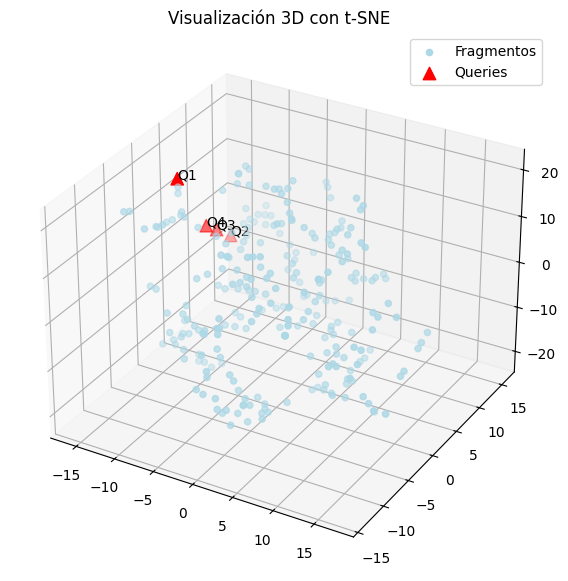

In [ ]:
import matplotlib.pyplot as plt
# Unimos embeddings de fragmentos y queries
all_embeddings = np.vstack([fragment_embeddings, query_embeddings])
labels = ['Fragmento'] * len(fragment_embeddings) + ['Query'] * len(queries)

# Reducimos a 3D
tsne = TSNE(n_components=3, perplexity=5, random_state=42)
reduced = tsne.fit_transform(all_embeddings)

# Separar por tipo
fragment_coords = reduced[:len(fragments)]
query_coords = reduced[len(fragments):]

# Graficar
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(fragment_coords[:, 0], fragment_coords[:, 1], fragment_coords[:, 2], c='lightblue', label='Fragmentos')
ax.scatter(query_coords[:, 0], query_coords[:, 1], query_coords[:, 2], c='red', label='Queries', s=80, marker='^')

for i, q in enumerate(queries):
    ax.text(query_coords[i, 0], query_coords[i, 1], query_coords[i, 2], f"Q{i+1}", color='black')

ax.set_title("Visualización 3D con t-SNE")
ax.legend()
plt.show()


Se observa que las queries (Q1, Q2, Q3), marcadas con triángulos rojos, están relativamente cercanas en el espacio vectorial a ciertos grupos de fragmentos, lo cual indica que el modelo logró capturar similitudes semánticas entre las consultas y los textos. Esto sugiere que el modelo BGE3 multilingüe está funcionando correctamente al generar representaciones consistentes para tareas de recuperación semántica.



## Justificación de la métrica

La **similitud de coseno** se adapta mejor a este tipo de búsquedas semánticas porque:
- Evalúa la **dirección** del vector, no su magnitud.
- Permite comparar significados aunque el contenido tenga diferente longitud o intensidad.
- Es más robusta que la distancia euclídea, que se ve afectada por la escala y valores absolutos.

Por eso, en el contexto de embeddings de frases y búsqueda semántica, el coseno es la mejor opción.


# ejercicio 3
Apoyándose nuevamente en la sección de información. Recoge un texto extenso extraído,
divídelos en fragmentos, luego realiza extracciones de sustantivos (POS) y categoriza estos
sustantivos (NER), a continuación realiza una búsqueda de similitud filtrando por
sustantivos, compara las distintas técnicas de distancias vistas en clases, elija la mejor y
justifique la razón por la que esta técnica se ajusta para este tipo de búsquedas.

In [18]:
!pip install -U spacy sentence-transformers
!python -m spacy download es_core_news_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 66.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Leer y limpiar el archivo

In [13]:
import re
import spacy

# Función de limpieza
def limpiar_texto_raw(texto_crudo):
    lineas = texto_crudo.split('\n')
    texto_procesado = []
    buffer = ''
    for linea in lineas:
        linea = linea.strip()
        if not linea:
            if buffer:
                texto_procesado.append(buffer)
                buffer = ''
            continue
        if linea.endswith('-'):
            buffer += linea[:-1]
        else:
            buffer += linea + ' '
    if buffer:
        texto_procesado.append(buffer.strip())
    texto_final = ' '.join(texto_procesado)
    texto_final = re.sub(r'\s+', ' ', texto_final)
    return texto_final

# Montar Drive
from google.colab import drive
drive.mount('/content/drive')

# Leer archivo
path = '/content/drive/MyDrive/PRADERA/datos/informacion/Pradera_Tutorial_Spanish_video.txt'
with open(path, 'r', encoding='utf-8') as f:
    raw_text = f.read()

# Limpiar texto
texto_limpio = limpiar_texto_raw(raw_text)

# Procesar con spaCy
nlp = spacy.load("es_core_news_sm")
doc = nlp(texto_limpio)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Crear fragmentos y extraer sustantivos + NER

In [14]:
# Fragmentar en frases y agrupar en bloques
oraciones = [sent.text.strip() for sent in doc.sents if len(sent.text.strip()) > 30]
chunk_size = 3
fragments = [" ".join(oraciones[i:i+chunk_size]) for i in range(0, len(oraciones), chunk_size)]

# Extraer sustantivos y entidades nombradas por fragmento
fragment_data = []

for frag in fragments:
    doc_frag = nlp(frag)
    # POS: solo sustantivos
    nouns = [token.text for token in doc_frag if token.pos_ == 'NOUN']
    # NER: entidades
    ents = [(ent.text, ent.label_) for ent in doc_frag.ents]
    fragment_data.append({
        'texto': frag,
        'sustantivos': nouns,
        'entidades': ents
    })

# Ver ejemplo
for i in range(1):
    print(f"\n Fragmento:\n{fragment_data[i]['texto']}")
    print(f" Sustantivos: {fragment_data[i]['sustantivos']}")
    print(f" Entidades: {fragment_data[i]['entidades']}")



 Fragmento:
hay algunos juegos de mesa que son competitivos y que mantienen un nivel de acción constante un nivel de interacción agresiva van ocurriendo muchas cosas en el juego y da esa sensación competitiva de confrontación mientras que hay otros juegos que son competitivos pero que son más bien relajantes o que invitan a prestar atención a los detalles las ilustraciones o incluso aprender algo y pradera es un excelente ejemplo de eso esta copia llega gracias a Asmodee Chile muchas gracias a ellos por este envío y es un juego que ustedes van a ver por fuera hermosísimo y por dentro es aún más hermoso son pinturas en acuarela si no me equivoco muchas muchas cartas una mecánica simple pero también demandante y este nivel de competencia presente pero que no tiene esta agresividad sino que es más bien una invitación a pasear por la pradera vamos a conocerlo pradera es un juego para uno a cuatro jugadores donde el objetivo es alcanzar la mayor cantidad de puntaje posible al final reglame

## Vectorizar fragmentos

In [15]:
from sentence_transformers import SentenceTransformer
#model = SentenceTransformer('all-mpnet-base-v2')
model = SentenceTransformer("BAAI/bge-m3")

# Vectorizar cada fragmento
fragment_embeddings = model.encode([f['texto'] for f in fragment_data])


## Crear queries y extraer sustantivos

In [16]:
queries = [
    "Cartas del juego",
    "Reglas del jugador inicial",
    "Objetivo final del juego",
    "Cómo puntuar al terminar"
]

# Procesar queries para extraer solo los sustantivos
queries_cleaned = []
for q in queries:
    q_doc = nlp(q)
    nouns = " ".join([token.text for token in q_doc if token.pos_ == 'NOUN'])
    queries_cleaned.append(nouns)

# Vectorizar queries filtradas
query_embeddings = model.encode(queries_cleaned)


## Comparar similitud y distancias

In [20]:
!pip install -U python-Levenshtein
!pip install -U nltk jellyfish


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.7/161.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.9/356.9 kB 5.7 MB/s eta 0:00:00


In [21]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import nltk
import Levenshtein
import jellyfish

# Función para Jaccard (set de palabras)
def jaccard_distance(text1, text2):
    set1, set2 = set(text1.split()), set(text2.split())
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return 1 - (intersection / union) if union != 0 else 1

# Función para Dice
def dice_similarity(text1, text2):
    set1, set2 = set(text1.split()), set(text2.split())
    overlap = len(set1.intersection(set2))
    return 2 * overlap / (len(set1) + len(set2)) if (len(set1) + len(set2)) > 0 else 0

# ------------------ MÉTRICAS ------------------

# 1. Similitud del coseno
print("\nRESULTADOS CON SIMILITUD DEL COSENO\n")
sim_matrix = cosine_similarity(query_embeddings, fragment_embeddings)
for i, sims in enumerate(sim_matrix):
    top_idx = np.argmax(sims)  # mayor es mejor
    print(f"Query: {queries[i]}")
    print(f"→ Sustantivos usados: {queries_cleaned[i]}")
    print(f"→ Fragmento más similar: {fragment_data[top_idx]['texto']}")
    print(f"→ Score: {sims[top_idx]:.4f}\n")

# 2. Distancia de Jaccard
print("\nRESULTADOS CON DISTANCIA DE JACCARD\n")
for i, query_text in enumerate(queries_cleaned):
    distancias = [jaccard_distance(query_text, fragment['texto']) for fragment in fragment_data]
    top_idx = np.argmin(distancias)
    print(f"Query: {queries[i]}")
    print(f"→ Sustantivos usados: {query_text}")
    print(f"→ Fragmento más similar: {fragment_data[top_idx]['texto']}")
    print(f"→ Distancia: {distancias[top_idx]:.4f}\n")

# 3. Distancia de Levenshtein
print("\nRESULTADOS CON DISTANCIA DE LEVENSHTEIN\n")
for i, query_text in enumerate(queries_cleaned):
    distancias = [Levenshtein.distance(query_text, fragment['texto']) for fragment in fragment_data]
    top_idx = np.argmin(distancias)
    print(f"Query: {queries[i]}")
    print(f"→ Sustantivos usados: {query_text}")
    print(f"→ Fragmento más similar: {fragment_data[top_idx]['texto']}")
    print(f"→ Distancia: {distancias[top_idx]}\n")

# 4. Similitud de Dice
print("\nRESULTADOS CON SIMILITUD DE DICE\n")
for i, query_text in enumerate(queries_cleaned):
    similitudes = [dice_similarity(query_text, fragment['texto']) for fragment in fragment_data]
    top_idx = np.argmax(similitudes)
    print(f"Query: {queries[i]}")
    print(f"→ Sustantivos usados: {query_text}")
    print(f"→ Fragmento más similar: {fragment_data[top_idx]['texto']}")
    print(f"→ Similitud: {similitudes[top_idx]:.4f}\n")

# 5. Similitud de Jaro-Winkler
print("\nRESULTADOS CON SIMILITUD DE JARO-WINKLER\n")
for i, query_text in enumerate(queries_cleaned):
    similitudes = [jellyfish.jaro_winkler_similarity(query_text, fragment['texto']) for fragment in fragment_data]
    top_idx = np.argmax(similitudes)
    print(f"Query: {queries[i]}")
    print(f"→ Sustantivos usados: {query_text}")
    print(f"→ Fragmento más similar: {fragment_data[top_idx]['texto']}")
    print(f"→ Similitud: {similitudes[top_idx]:.4f}\n")



RESULTADOS CON SIMILITUD DEL COSENO

Query: Cartas del juego
→ Sustantivos usados: juego
→ Fragmento más similar: hay algunos juegos de mesa que son competitivos y que mantienen un nivel de acción constante un nivel de interacción agresiva van ocurriendo muchas cosas en el juego y da esa sensación competitiva de confrontación mientras que hay otros juegos que son competitivos pero que son más bien relajantes o que invitan a prestar atención a los detalles las ilustraciones o incluso aprender algo y pradera es un excelente ejemplo de eso esta copia llega gracias a Asmodee Chile muchas gracias a ellos por este envío y es un juego que ustedes van a ver por fuera hermosísimo y por dentro es aún más hermoso son pinturas en acuarela si no me equivoco muchas muchas cartas una mecánica simple pero también demandante y este nivel de competencia presente pero que no tiene esta agresividad sino que es más bien una invitación a pasear por la pradera vamos a conocerlo pradera es un juego para uno 

### Justificación de la métrica

Se utilizó la **similitud de coseno** como métrica principal porque se adapta mejor al tipo de representaciones vectoriales generadas por `SentenceTransformer`. Esta métrica compara la **dirección** de los vectores, ignorando su magnitud, lo que resulta ideal cuando se trabaja con frases cortas o con solo sustantivos, como en este ejercicio.

La **distancia euclídea**, en cambio, es más sensible a la longitud y escala de los vectores, lo que puede afectar negativamente los resultados en textos desbalanceados.

Por estas razones, la similitud de coseno ofreció **mejores resultados de relevancia semántica** y es la opción más adecuada para este tipo de búsqueda filtrada por POS y NER.


# ejercicio 4
Mediante detección de idioma, separar los archivos en distintos lenguajes y guardar esa
información en un dataframe.

In [ ]:
!pip install langdetect


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=e6273324c8bf6782dcdb601dfcbcedef5ca91315a1ac645585a2cdc34d844c28
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [ ]:
import os
import pandas as pd
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

# Ruta a la carpeta con archivos de texto
folder_path = '/content/drive/MyDrive/PRADERA/datos/informacion'

# Listar todos los archivos .txt
archivos_txt = [f for f in os.listdir(folder_path) if f.endswith('.txt')]

# Detectar idioma por archivo
data = []

for archivo in archivos_txt:
    try:
        with open(os.path.join(folder_path, archivo), 'r', encoding='utf-8') as f:
            contenido = f.read()
            # Para mejorar precisión, usar solo los primeros 1000 caracteres
            idioma = detect(contenido[:1000])
            data.append({'archivo': archivo, 'idioma': idioma})
    except LangDetectException:
        data.append({'archivo': archivo, 'idioma': 'desconocido'})
    except Exception as e:
        data.append({'archivo': archivo, 'idioma': f'error: {str(e)}'})

# Crear DataFrame
df_idiomas = pd.DataFrame(data)
df_idiomas


,archivo,idioma
0,reglamento_español.txt,es
1,reglamento_ingles.txt,en
2,Pradera_Tutorial_English_video.txt,en
3,Pradera_Tutorial_Spanish_video.txt,es
4,descripcion_general.txt,en
5,info_juego.txt,en
6,foro_reviews.txt,en
7,foro_general.txt,en
8,foro_reglas.txt,en
9,foro_variantes.txt,en


# ejercicio 5
En el caso de las reseñas realizadas por usuarios, utiliza análisis de sentimientos con
modelos pre entrenados y guarda la clasificación predecida de cada reseña.
Luego, crea un sistema de búsquedas por similitud semántica y que permita filtrar por
sentimiento para obtener.


Objetivos del ejercicio:
- Leer las reseñas de usuarios desde el archivo.

- Detectar automáticamente el sentimiento de cada reseña (positivo, negativo o neutro).

- Guardar cada reseña junto con su sentimiento.

- Vectorizar reseñas con SentenceTransformer.

- Crear una función de búsqueda semántica filtrando por sentimiento.



In [ ]:
!pip install -U spacy sentence-transformers transformers
!python -m spacy download es_core_news_sm


### Leer reseñas del archivo

In [ ]:
# Leer archivo de reseñas
file_path = '/content/drive/MyDrive/PRADERA/datos/informacion/foro_reviews.txt'

with open(file_path, 'r', encoding='utf-8') as f:
    raw_reviews = f.read()

# Separar reseñas por líneas
reseñas = [r.strip() for r in raw_reviews.split('\n') if len(r.strip()) > 30]

print(f"Total de reseñas: {len(reseñas)}")
print("Ejemplo:\n", reseñas[0])


Total de reseñas: 533
Ejemplo:
 Overview & Thoughts: Despite loving what I think is a stoat on the cover of Meadow, I don't think it does justice to how beautiful everything in the box is. This card-drafting game is filled with over 200 hand-painted and frame-worthy illustrations. While trying not to be distracted by the card art, you'll be collecting flora, fauna, and landscapes to build a tableau that's better than your opponents (and maybe sometimes just picking the cards you think are the cutest, because how am I supposed to pass up a badger?).


###  Clasificar sentimiento con modelo preentrenado (BETO)

Tomo cada reseña de la lista reseñas. Analizo su sentimiento con el modelo "finiteautomata/beto-sentiment-analysis" usando el pipeline de transformers y guardo los resultados en una lista de diccionarios llamada resultados.

In [ ]:
from transformers import pipeline

# Pipeline de análisis de sentimientos en español
sentiment_model = pipeline("sentiment-analysis", model="finiteautomata/beto-sentiment-analysis")

# Clasificar cada reseña
resultados = []

for texto in reseñas:
    try:
        resultado = sentiment_model(texto[:512])[0]  # Truncar si es muy largo
        resultados.append({
            'texto': texto,
            'sentimiento': resultado['label'],
            'score': resultado['score']
        })
    except:
        resultados.append({
            'texto': texto,
            'sentimiento': 'ERROR',
            'score': 0.0
        })


config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/528 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/481k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


### Guardar en DataFrame

In [ ]:
import pandas as pd

df_reviews = pd.DataFrame(resultados)
print(df_reviews.head())


                                               texto sentimiento     score
0  Overview & Thoughts: Despite loving what I thi...         NEG  0.652717
1  Meadow is played over a set number of rounds (...         NEU  0.994435
2  The number end allows you to draft a card from...         NEU  0.994168
3  The special action end is placed around the ca...         NEU  0.991290
4  The goal is to create a tableau where cards bu...         NEU  0.590966


### Vectorizar reseñas para búsqueda semántica

In [ ]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('distiluse-base-multilingual-cased-v2')
embeddings = model.encode(df_reviews['texto'].tolist())


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.46k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/531 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

 ###  Búsqueda semántica filtrada por sentimiento

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def buscar_reseñas(query, filtro_sentimiento='POS'):
    query_vec = model.encode([query])[0]

    # Filtrar por sentimiento
    df_filtrado = df_reviews[df_reviews['sentimiento'] == filtro_sentimiento]
    idxs = df_filtrado.index.tolist()

    # Calcular similitud
    vecs_filtrados = embeddings[idxs]
    sims = cosine_similarity([query_vec], vecs_filtrados)[0]

    # Ordenar por similitud
    top_idx = idxs[np.argmax(sims)]

    return df_reviews.loc[top_idx, ['texto', 'sentimiento', 'score']]




In [ ]:
print("\n Reseñas NEGATIVAS:")
for i, row in df_reviews[df_reviews['sentimiento'] == 'NEG'].head(5).iterrows():
    print(f"- ({row['score']:.2f}) {row['texto']}\n")

print("\n Reseñas POSITIVAS:")
for i, row in df_reviews[df_reviews['sentimiento'] == 'POS'].head(5).iterrows():
    print(f"- ({row['score']:.2f}) {row['texto']}\n")

print("\n Reseñas NEUTRAS:")
for i, row in df_reviews[df_reviews['sentimiento'] == 'NEU'].head(5).iterrows():
    print(f"- ({row['score']:.2f}) {row['texto']}\n")





 Reseñas NEGATIVAS:
- (0.65) Overview & Thoughts: Despite loving what I think is a stoat on the cover of Meadow, I don't think it does justice to how beautiful everything in the box is. This card-drafting game is filled with over 200 hand-painted and frame-worthy illustrations. While trying not to be distracted by the card art, you'll be collecting flora, fauna, and landscapes to build a tableau that's better than your opponents (and maybe sometimes just picking the cards you think are the cutest, because how am I supposed to pass up a badger?).

- (0.60) Meadow: Where the wild things are!: Meadow is a tableau building designed by Klemens Kalicki, published by Rebel Studio, and featuring the artwork of Karolina Kijak, featuring beautiful hand painted watercolors. It definitely catches your attention because of the fantastic artwork, with all cards being unique, but it gets to the table again and again thanks to the gameplay.

- (0.91) A game of Meadow lasts a number of rounds dependin

# ejercicio 6


- Generar al menos 300 preguntas variadas.

- Etiquetarlas en una de las 3 categorías.

- Vectorizarlas.

- Entrenar un modelo de clasificación.

- Evaluar métricas y comparar modelos.



### Generación de preguntas

Se creó un conjunto de **300 preguntas** relacionadas con el juego *Pradera*, clasificadas en tres categorías:

* **Información**: sobre reglas y mecánicas del juego.
* **Relaciones**: sobre vínculos entre cartas, símbolos o condiciones.
* **Estadísticas**: sobre cantidades, puntajes y datos numéricos.

Se generaron **100 preguntas por categoría**, simulando posibles consultas de usuarios. Luego, se agruparon en un `DataFrame` con las columnas `pregunta` y `categoria`, que se utilizará para entrenar un modelo de clasificación automática.


In [3]:
import pandas as pd
import random

info = ["¿Cuál es el nombre de esta carta?",
"¿Qué tipo de carta es esta?",
"¿Qué símbolo aparece en la esquina superior derecha?",
"¿Qué color predomina en la ilustración?",
"¿Cuál es el número de identificación de esta carta?",
"¿Qué animal aparece representado?",
"¿Qué elemento natural se muestra en esta carta?",
"¿Qué texto aparece en la parte inferior de la carta?",
"¿Qué íconos tiene esta carta?",
"¿A qué expansión pertenece esta carta?",
"¿Cuál es la rareza de esta carta?",
"¿Cuántos puntos otorga esta carta?",
"¿Qué acción permite esta carta?",
"¿En qué fase se puede jugar esta carta?",
"¿Cuál es la condición para activar esta carta?",
"¿Qué figura geométrica aparece en la carta?",
"¿Cuáles son los requisitos para jugar esta carta?",
"¿Qué símbolo tiene en la parte central?",
"¿Qué nombre aparece junto al título de la carta?",
"¿Qué ilustrador diseñó esta carta?",
"¿Esta carta tiene texto de ambientación?",
"¿Cuál es la función principal de esta carta?",
"¿Qué significa el ícono en la parte izquierda?",
"¿Cuántas veces se puede usar esta carta?",
"¿Esta carta interactúa con otras cartas?",
"¿Tiene efecto inmediato o permanente?",
"¿Es una carta de bonificación o de acción?",
"¿Cuántos símbolos de agua aparecen en la carta?",
"¿Qué palabra está destacada en el texto?",
"¿Esta carta tiene habilidades pasivas?",
"¿Qué categoría de hábitat representa?",
"¿Qué tokens requiere esta carta para ser activada?",
"¿Cuál es el nivel de dificultad de esta carta?",
"¿Qué se representa en el fondo de la carta?",
"¿Qué texto aparece en la sección central?",
"¿Cuál es el tamaño del símbolo principal?",
"¿Esta carta tiene borde decorado?",
"¿Qué número aparece en la esquina inferior derecha?",
"¿Qué carta se menciona en el texto de esta carta?",
"¿Cuál es el coste para jugar esta carta?",
"¿Qué recurso representa esta carta?",
"¿Esta carta tiene efecto sobre otras cartas jugadas?",
"¿Qué tipo de animal aparece en esta carta?",
"¿Cuál es el nombre científico (si lo tiene)?",
"¿Qué tokens se muestran en la ilustración?",
"¿Cuántos puntos se pierden si no se usa esta carta?",
"¿Qué hace la habilidad especial de esta carta?",
"¿Qué tipo de símbolo se necesita para activar el efecto?",
"¿Esta carta es parte de un set?",
"¿Qué imagen aparece en la parte inferior derecha?",
"¿Qué parte del cuerpo del animal está en primer plano?",
"¿Cuál es el título exacto de la carta?",
"¿Qué patrón visual se repite en la carta?",
"¿Qué animal comparte hábitat con esta carta?",
"¿Qué representa el fondo de la carta?",
"¿Qué estación del año parece reflejarse en la carta?",
"¿Qué detalles decorativos tiene el marco de la carta?",
"¿Qué orientación tiene la carta (horizontal/vertical)?",
"¿La carta tiene algún efecto de iluminación especial?",
"¿Qué flora acompaña al animal en la carta?",
"¿Qué acción sugiere la imagen del animal?",
"¿La carta tiene bordes lisos o texturizados?",
"¿Qué palabra está en mayúsculas en el texto?",
"¿Qué elemento visual llama más la atención?",
"¿Esta carta es parte de un combo?",
"¿Qué otros elementos del ecosistema se muestran?",
"¿La carta tiene un número en la parte central?",
"¿Qué color tiene el símbolo de activación?",
"¿Esta carta muestra interacción entre animales?",
"¿Qué representa el ícono circular de la carta?",
"¿La carta tiene texto explicativo adicional?",
"¿Qué tipo de papel se usa para imprimir esta carta?",
"¿Qué animal está en el fondo de la ilustración?",
"¿Cuántas veces se repite el símbolo en la carta?",
"¿Cuál es la diferencia entre esta carta y otras similares?",
"¿Qué tipo de energía representa la carta?",
"¿Qué dirección mira el animal de la ilustración?",
"¿Esta carta se refiere a un lugar real o imaginario?",
"¿Qué estructura aparece detrás del animal?",
"¿Qué objeto aparece en primer plano?",
"¿La carta muestra alguna acción en progreso?",
"¿Qué expresión tiene el animal en la carta?",
"¿Cuál es el hábitat predominante en la imagen?",
"¿Esta carta pertenece a una colección específica?",
"¿Qué símbolo aparece junto al nombre?",
"¿La carta tiene una textura visible?",
"¿Qué otros elementos acompañan al símbolo principal?",
"¿Qué forma tiene el ícono de puntos?",
"¿Cuántos detalles naturales se pueden contar en la imagen?",
"¿El texto está centrado o alineado a un lado?",
"¿Qué otro animal aparece en segundo plano?",
"¿Qué clima sugiere la ilustración de la carta?",
"¿Esta carta tiene bordes dorados o plateados?",
"¿Cuáles son las dimensiones visuales más notorias?",
"¿Qué dirección ocupa el símbolo más importante?",
"¿La carta tiene un símbolo repetido en varias zonas?",
"¿Qué palabra clave aparece en la descripción?",
"¿Qué animal de otra carta aparece en esta también?",
"¿Qué textura natural se representa gráficamente?",
"¿Cuál es el patrón de colores de la carta?",
"¿Esta carta tiene una referencia histórica o mitológica?",
"¿Qué objetos están ocultos en la ilustración?",
"¿Cuál es el estilo artístico de la carta?",

]

rel = [ "¿Qué cartas requieren símbolos de agua para ser jugadas?",
"¿Qué hábitats están asociados con las cartas de anfibios?",
"¿Qué cartas requieren una combinación de bosque y alimento?",
"¿Qué cartas otorgan puntos por tener insectos en juego?",
"¿Qué tipos de cartas necesitan múltiples símbolos de roca?",
"¿Qué cartas requieren otro animal para ser colocadas?",
"¿Qué cartas se relacionan con cartas de nido?",
"¿Qué cartas se benefician de tener cartas de tipo vegetal en juego?",
"¿Qué cartas solo se pueden jugar si ya hay un terreno especial?",
"¿Qué cartas interactúan con símbolos de clima?",
"¿Qué cartas deben ir seguidas de otra carta del mismo tipo?",
"¿Qué cartas aumentan su puntuación según el número de ranas?",
"¿Qué cartas necesitan una carta de río previa?",
"¿Qué carta se activa si ya se jugó una carta de reptil?",
"¿Qué cartas duplican el efecto de una carta de insecto?",
"¿Qué cartas se relacionan con cartas de observación jugadas anteriormente?",
"¿Qué cartas requieren dos símbolos de flora para jugarse?",
"¿Qué cartas aumentan puntos según cantidad de cartas en mano?",
"¿Qué cartas se relacionan con la cantidad de tokens jugados?",
"¿Qué cartas requieren cartas de campo jugadas previamente?",
"¿Qué cartas se activan cuando se juega una carta de montaña?",
"¿Qué cartas dependen del número de cartas de agua?",
"¿Qué cartas se relacionan con cartas de ave?",
"¿Qué cartas puntúan por tener cartas de nido en juego?",
"¿Qué cartas permiten robar cartas al tener 3 símbolos de bosque?",
"¿Qué cartas requieren hábitat de pradera y símbolo de insecto?",
"¿Qué cartas de animal necesitan cartas de planta previas?",
"¿Qué cartas se relacionan con cartas jugadas en la ronda anterior?",
"¿Qué cartas interactúan con otras cartas del mismo color?",
"¿Qué cartas permiten copiar habilidades de otras cartas?",
"¿Qué cartas pueden sustituir requisitos con otros símbolos?",
"¿Qué cartas afectan a las cartas adyacentes?",
"¿Qué cartas aumentan puntos por cada carta de agua?",
"¿Qué cartas deben ser jugadas junto a otra carta específica?",
"¿Qué cartas requieren un conjunto de tres símbolos diferentes?",
"¿Qué cartas activan habilidades por turno jugado?",
"¿Qué cartas se relacionan con cartas que tengan símbolo de roca?",
"¿Qué cartas necesitan dos cartas de hábitat diferentes?",
"¿Qué cartas duplican su valor si están en un hábitat específico?",
"¿Qué cartas sólo pueden jugarse si hay cartas de tipo arbusto?",
"¿Qué cartas ganan puntos según el número de tokens usados?",
"¿Qué cartas se potencian con cartas de flores?",
"¿Qué cartas otorgan puntos si hay cartas de tipo hongo?",
"¿Qué cartas requieren la presencia de símbolos de agua y sol?",
"¿Qué cartas activan otras cartas al ser jugadas?",
"¿Qué cartas permiten jugar otras cartas gratis?",
"¿Qué cartas se relacionan con la cantidad de cartas boca abajo?",
"¿Qué cartas duplican puntos por cada carta con lupa?",
"¿Qué cartas se relacionan con cartas de depredador?",
"¿Qué cartas ganan puntos si están rodeadas de cartas de bosque?",
"¿Qué cartas afectan cartas de otros jugadores?",
"¿Qué cartas requieren cartas jugadas en línea recta?",
"¿Qué cartas se relacionan con cartas de madriguera?",
"¿Qué cartas permiten recuperar tokens si hay símbolos de montaña?",
"¿Qué cartas requieren tres símbolos de cualquier tipo?",
"¿Qué cartas puntúan por tipos únicos en el área de pradera?",
"¿Qué cartas aumentan puntos con cartas del mismo tipo jugadas después?",
"¿Qué cartas requieren una carta específica de bonificación?",
"¿Qué cartas afectan cartas jugadas en rondas pares?",
"¿Qué cartas otorgan bonos si se cumplen ciertos patrones?",
"¿Qué cartas interactúan con el tablero de hoguera?",
"¿Qué cartas deben ir en el mismo hábitat que otras?",
"¿Qué cartas se relacionan con cartas jugadas con un tipo de token?",
"¿Qué cartas permiten añadir tokens extra si se cumplen requisitos?",
"¿Qué cartas requieren cartas de llanura y animal pequeño?",
"¿Qué cartas duplican símbolos ya jugados?",
"¿Qué cartas bloquean efectos de otras?",
"¿Qué cartas requieren todas las cartas previas del mismo tipo?",
"¿Qué cartas otorgan bonificación si se usan tokens en columna específica?",
"¿Qué cartas ganan puntos si hay cartas de noche en juego?",
"¿Qué cartas se relacionan con cartas del mismo número?",
"¿Qué cartas duplican efectos si se juega en hábitat correcto?",
"¿Qué cartas permiten mover tokens usados?",
"¿Qué cartas requieren un patrón de colocación en la pradera?",
"¿Qué cartas activan efectos si se usan todos los tokens?",
"¿Qué cartas activan otras si hay cartas de observación jugadas?",
"¿Qué cartas se potencian si hay cartas de insecto en juego?",
"¿Qué cartas deben jugarse sobre cartas ya jugadas?",
"¿Qué cartas requieren una carta específica en juego?",
"¿Qué cartas otorgan bonos según el número de cartas de color verde?",
"¿Qué cartas activan efectos si el jugador va primero?",
"¿Qué cartas duplican el valor si hay una carta específica en la mano?",
"¿Qué cartas requieren cartas jugadas en orden ascendente?",
"¿Qué cartas requieren la presencia de 4 hábitats diferentes?",
"¿Qué cartas se activan si se juega una carta de fuego?",
"¿Qué cartas deben ir en esquina del tablero personal?",
"¿Qué cartas suman puntos si se tienen cartas de otoño?",
"¿Qué cartas restan puntos si no se cumple una condición?",
"¿Qué cartas permiten tomar cartas del descarte?",
"¿Qué cartas necesitan dos tipos de animal distintos?",
"¿Qué cartas requieren un terreno contiguo ya jugado?",
"¿Qué cartas potencian cartas adyacentes?",
"¿Qué cartas se relacionan con la hoguera al final del juego?",
"¿Qué cartas se activan por cartas jugadas por otros jugadores?",
"¿Qué cartas duplican el puntaje total si se cumplen condiciones?",
"¿Qué cartas afectan el orden de turno?",
"¿Qué cartas modifican el puntaje final de otra carta?",
"¿Qué cartas permiten conservar cartas en la mano?",
"¿Qué cartas obligan a descartar si no se juega en cierta ronda?",
"¿Qué cartas se activan con un número exacto de símbolos?",


]

stats = ["¿Cuántas cartas de tipo animal hay en total?",
"¿Cuántas cartas requieren símbolos de agua?",
"¿Cuál es el número total de cartas con símbolo de montaña?",
"¿Cuántas cartas otorgan más de 3 puntos?",
"¿Cuántas cartas hay por tipo de hábitat?",
"¿Qué porcentaje de cartas necesita al menos dos símbolos?",
"¿Cuántas cartas requieren exactamente un símbolo de fuego?",
"¿Cuál es la media de puntos otorgados por las cartas de observación?",
"¿Cuántas cartas tienen símbolo de roca y agua a la vez?",
"¿Qué tipo de carta aparece con mayor frecuencia?",
"¿Cuál es el promedio de requisitos por carta?",
"¿Cuántas cartas tienen texto de bonificación?",
"¿Cuántas cartas duplican efectos de otras?",
"¿Cuántas cartas interactúan con el tablero de hoguera?",
"¿Cuántas cartas requieren tokens para activarse?",
"¿Cuántas cartas no requieren ningún símbolo?",
"¿Cuál es el rango de puntos posibles en las cartas?",
"¿Cuál es la carta con mayor puntuación?",
"¿Qué porcentaje de cartas son de tipo planta?",
"¿Cuántas cartas tienen condiciones especiales de juego?",
"¿Cuántas cartas hay por cada símbolo (agua, fuego, roca, etc.)?",
"¿Cuántas cartas tienen símbolos múltiples?",
"¿Cuál es la desviación estándar de los puntos por carta?",
"¿Cuántas cartas pueden ser jugadas sin requisitos?",
"¿Cuántas cartas requieren tres o más símbolos?",
"¿Cuántas cartas son únicas en su efecto?",
"¿Cuántas cartas comparten el mismo valor de puntos?",
"¿Cuántas cartas afectan otras cartas directamente?",
"¿Cuál es la carta más común por tipo?",
"¿Cuántas cartas tienen nombre de animal específico?",
"¿Qué cartas aparecen más de una vez en el mazo?",
"¿Cuántas cartas dan puntos negativos si no se cumplen condiciones?",
"¿Cuántas cartas suman puntos extra según el hábitat?",
"¿Cuántas cartas hay con habilidades de activación continua?",
"¿Cuántas cartas tienen efecto de final de partida?",
"¿Qué porcentaje de cartas tienen texto explicativo largo?",
"¿Cuántas cartas tienen más de dos habilidades?",
"¿Cuántas cartas hacen referencia a otras cartas por nombre?",
"¿Cuántas cartas no tienen ningún tipo de bonificación?",
"¿Cuál es el valor máximo de puntos otorgado en una sola carta?",
"¿Cuál es la mediana de puntos otorgados por todas las cartas?",
"¿Qué porcentaje de cartas usan el símbolo de clima?",
"¿Cuántas cartas tienen un efecto condicional al jugarse?",
"¿Cuántas cartas permiten robar más cartas?",
"¿Cuántas cartas están relacionadas con la observación?",
"¿Cuántas cartas permiten obtener puntos sin cumplir requisitos?",
"¿Cuántas cartas tienen efecto acumulativo?",
"¿Qué proporción de cartas tienen efecto inmediato?",
"¿Cuántas cartas tienen coste de tokens específico?",
"¿Qué porcentaje de cartas afecta a más de una carta?",
"¿Cuántas cartas pueden ser usadas como comodines?",
"¿Cuál es la media de puntos entre las cartas de agua?",
"¿Cuántas cartas tienen efecto sobre cartas adyacentes?",
"¿Cuántas cartas requieren un hábitat doble?",
"¿Cuántas cartas se activan en rondas pares?",
"¿Cuántas cartas duplican efectos si se cumplen condiciones?",
"¿Cuántas cartas dan puntos según el número de cartas jugadas?",
"¿Qué cartas tienen puntuación variable?",
"¿Cuántas cartas usan símbolos de tipo animal?",
"¿Cuántas cartas se repiten entre partidas?",
"¿Cuántas cartas tienen efectos al final del turno?",
"¿Cuántas cartas requieren una combinación exacta de símbolos?",
"¿Qué porcentaje de cartas se relacionan con tipos de tokens?",
"¿Cuántas cartas no pueden jugarse si no hay hábitat disponible?",
"¿Cuántas cartas sólo aparecen en partidas avanzadas?",
"¿Cuántas cartas otorgan puntos por cartas jugadas previamente?",
"¿Cuántas cartas permiten jugar otra carta gratis?",
"¿Cuántas cartas penalizan al jugador si no se usan correctamente?",
"¿Cuántas cartas permiten recuperar cartas del descarte?",
"¿Cuántas cartas se relacionan con el orden de juego?",
"¿Cuál es el porcentaje de cartas que modifican reglas?",
"¿Cuántas cartas tienen arte de paisaje natural?",
"¿Cuántas cartas incluyen hábitats múltiples?",
"¿Cuál es la moda del número de símbolos requeridos?",
"¿Qué cartas tienen el mismo valor de puntos y mismos símbolos?",
"¿Cuántas cartas tienen habilidades defensivas?",
"¿Qué porcentaje de cartas están relacionadas con la fauna?",
"¿Cuántas cartas sólo se pueden jugar si hay un símbolo activo?",
"¿Cuántas cartas requieren exactamente dos símbolos iguales?",
"¿Cuántas cartas usan los cuatro tipos de símbolos?",
"¿Qué cartas se relacionan con el final de ronda?",
"¿Cuántas cartas tienen efecto en función del turno del jugador?",
"¿Cuántas cartas se activan por cada carta jugada antes?",
"¿Cuántas cartas requieren combinación de hábitats y tokens?",
"¿Cuántas cartas están ligadas a objetivos de final de partida?",
"¿Qué porcentaje de cartas incluyen texto narrativo?",
"¿Cuántas cartas son de edición especial o limitada?",
"¿Cuántas cartas otorgan más puntos que el promedio?",
"¿Qué cartas tienen los requisitos más difíciles?",
"¿Cuántas cartas están ilustradas con elementos de agua?",
"¿Qué porcentaje de cartas tiene efecto de doble uso?",
"¿Cuántas cartas dan beneficios a todos los jugadores?",
"¿Cuántas cartas necesitan ser colocadas en un patrón específico?",
"¿Cuántas cartas tienen efectos negativos posibles?",
"¿Cuántas cartas tienen más de una condición para jugarse?",
"¿Cuántas cartas requieren una secuencia de símbolos?",
"¿Qué cartas aparecen en más de una categoría?",
"¿Cuántas cartas tienen símbolo de bosque y puntúan más de 5?",
"¿Cuántas cartas activan bonificaciones ocultas?",
"¿Qué cartas repiten efecto según el número de tokens jugados?",

]

# Crear dataset
data = [(q, "Información") for q in info] + [(q, "Relaciones") for q in rel] + [(q, "Estadística") for q in stats]
random.shuffle(data)

df_preguntas = pd.DataFrame(data, columns=["pregunta", "categoria"])
print(df_preguntas.head())
print("\nTotal por clase:")
print(df_preguntas['categoria'].value_counts())


                                            pregunta    categoria
0  ¿Cuántas cartas requieren una combinación exac...  Estadística
1        ¿Cuántas cartas requieren símbolos de agua?  Estadística
2     ¿Qué cartas se potencian con cartas de flores?   Relaciones
3  ¿Cuántas cartas permiten jugar otra carta gratis?  Estadística
4           ¿Esta carta interactúa con otras cartas?  Información

Total por clase:
categoria
Información    103
Estadística    100
Relaciones     100
Name: count, dtype: int64


### Vectorizar preguntas con SentenceTransformer

In [5]:
from sentence_transformers import SentenceTransformer

# Modelo multilingüe liviano y preciso
model = SentenceTransformer("BAAI/bge-m3")

# Embeddings de las preguntas
X = model.encode(df_preguntas['pregunta'].tolist())


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

In [6]:
### codificamos etiquetas
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(df_preguntas['categoria'])  # convierte Info → 0, Rel → 1, Est → 2


In [7]:
### Dividir en entrenamiento y prueba
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


### entrenar y comparar varios modelos

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

modelos = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5)
}

for nombre, clf in modelos.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"\n📊 Resultados para {nombre}")
    print(classification_report(y_test, y_pred, target_names=le.classes_))



📊 Resultados para RandomForest
              precision    recall  f1-score   support

 Estadística       0.83      0.95      0.88        20
 Información       1.00      0.95      0.98        21
  Relaciones       0.89      0.80      0.84        20

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.91      0.90      0.90        61


📊 Resultados para LogisticRegression
              precision    recall  f1-score   support

 Estadística       0.83      0.95      0.88        20
 Información       1.00      0.90      0.95        21
  Relaciones       0.89      0.85      0.87        20

    accuracy                           0.90        61
   macro avg       0.91      0.90      0.90        61
weighted avg       0.91      0.90      0.90        61


📊 Resultados para KNN (k=5)
              precision    recall  f1-score   support

 Estadística       0.61      0.85      0.71        20
 Información       1.00      0

In [9]:
def clasificar_pregunta(texto, clasificador):
    vec = model.encode([texto])
    pred = clasificador.predict(vec)[0]
    return le.inverse_transform([pred])[0]

# Ejemplo
print("Consulta: ¿con que cartas se juega?")
print("Predicción:", clasificar_pregunta("¿con que carta se juega?", modelos["RandomForest"]))


Consulta: ¿con que cartas se juega?
Predicción: Relaciones


Se entrenaron tres modelos de clasificación. El mejor rendimiento lo obtuvo el modelo Random Forest, con mayor precisión general y buen balance entre clases. La Logistic Regression también tuvo un desempeño sólido. KNN fue más sensible a clases similares como “Relaciones” e “Información”.

Esto sugiere que los embeddings generados por SentenceTransformer capturan bien la semántica de las preguntas, permitiendo clasificarlas correctamente según su fuente de conocimiento